In [1]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


In [2]:
ANNOTATIONS_DIR = '../data/annotations/annotations averaged per song/song_level'
MFCC_DIR = '../data/mfcc'
METADATA_DIR = '../data/metadata'

df = pd.read_csv(f"{ANNOTATIONS_DIR}/static_annotations_averaged_songs_1_2000.csv", index_col='song_id')
print(df.shape)
df2 = pd.read_csv(f"{ANNOTATIONS_DIR}/static_annotations_averaged_songs_2000_2058.csv", index_col='song_id')
print(df2.shape)
for column in df2.columns.values:
   if column not in df.columns.values:
       df2 = df2.drop(column, axis = 1)
print(df2.shape)
df = df.append(df2)
print(df.values.shape)
song_ids = df.index.tolist()
print(len(song_ids))

(1744, 4)
(58, 12)
(58, 4)
(1802, 4)
1802


In [3]:
X = []
for song in song_ids:
    mfcc_df = pd.read_csv(f"{MFCC_DIR}/{song}.csv", header=None, index_col=0)
    song_mfcc = []
    for i in range(0,45,2):
        temp = mfcc_df.loc[i,1]
        temp = temp.replace('[', '')
        temp = temp.replace(']', '')
        temp = temp.replace('\n', '')
        song_mfcc_temp = [float(s) for s in temp.split()]
        song_mfcc.append(song_mfcc_temp)
    X.append(song_mfcc)
X = np.array(X)
X.shape

(1802, 23, 14)

In [4]:
y = []
for song in song_ids:
    y.append([df.loc[song].values[0], df.loc[song].values[2]])
y = np.array(y)
y.shape

(1802, 2)

In [5]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

input_shape = (X.shape[1], X.shape[2])
model = Sequential()
model.add(LSTM(32, input_shape=input_shape, dropout=0.05, recurrent_dropout=0.35))
model.add(Dense(2))

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['acc', 'mae'])
history = model.fit(X, y,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1441 samples, validate on 361 samples
Epoch 1/30
1441/1441 [==============================] - 2s 1ms/step - loss: 24.0279 - acc: 0.4615 - mean_absolute_error: 4.6768 - val_loss: 20.9463 - val_acc: 0.3657 - val_mean_absolute_error: 4.3790
Epoch 2/30
1441/1441 [==============================] - 0s 300us/step - loss: 19.6297 - acc: 0.4622 - mean_absolute_error: 4.1760 - val_loss: 15.9498 - val_acc: 0.3601 - val_mean_absolute_error: 3.7750
Epoch 3/30
1441/1441 [==============================] - 0s 228us/step - loss: 15.4275 - acc: 0.4663 - mean_absolute_error: 3.6376 - val_loss: 12.4548 - val_acc: 0.3712 - val_mean_absolute_error: 3.2851
Epoch 4/30
1441/1441 [==============================] - 0s 216us/step - loss: 12.1211 - acc: 0.4518 - mean_absolut

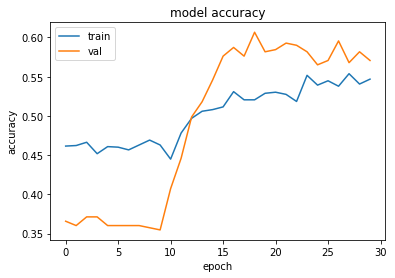

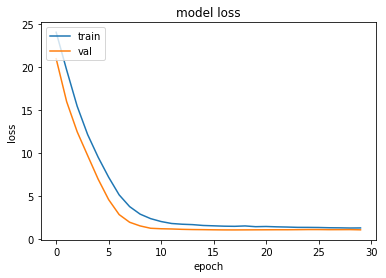

In [7]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# # summarize history for r2
# plt.plot(history.history['coeff_determination'])
# plt.plot(history.history['val_coeff_determination'])
# plt.title('model r2')
# plt.ylabel('r2')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [8]:
model.save('mfcc_trained.hd5')